In [1]:
abspath = '/Users/paolamartire/shocks'
import sys
sys.path.append(abspath)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
import healpy as hp
from Utilities.basic_units import radians
from src import orbits as orb
from Utilities import sections as sec
from Utilities.sections import make_slices
import Utilities.prelude as prel
from sklearn.neighbors import KDTree

from Utilities.operators import make_tree, to_spherical_components, to_cylindric
from Utilities.time_extractor import days_since_distruption

In [2]:
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5 # 'n1.5'
# gamma = 5/3
params = [Mbh, Rstar, mstar, beta]
check = 'HiResNewAMR' # '' or 'HiRes' or 'LowRes'
snap = '76'
compton = 'Compton'

folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}{compton}{check}' 
path = f'{abspath}/TDE/{folder}/{snap}'

params = [Mbh, Rstar, mstar, beta]
things = orb.get_things_about(params)
Rs = things['Rs']
Rt = things['Rt']
Rp = things['Rp']
R0 = things['R0']
apo = things['apo']
a_mb = things['a_mb']
E_mb = things['E_mb']
t_fb_days_cgs = things['t_fb_days'] * 24 * 3600 # in seconds
v_esc = np.sqrt(2*prel.G*Mbh/Rp)

# cfr tidal disruption and at smoothing lenght
xcfr, ycfr, cfr = orb.make_cfr(Rt)
xcfr0, ycfr0, cfr0 = orb.make_cfr(R0)
# cfr for grid
radii_grid = [R0, Rt, 0.3*apo, 0.5*apo, apo] 
styles = ['dotted', 'dashed', 'solid', 'solid', 'solid']
xcfr_grid, ycfr_grid, cfr_grid = [], [], []
for i,radius_grid in enumerate(radii_grid):
    xcr, ycr, cr = orb.make_cfr(radius_grid)
    xcfr_grid.append(xcr)
    ycfr_grid.append(ycr)
    cfr_grid.append(cr)

# HEALPIX
observers_xyz = hp.pix2vec(prel.NSIDE, range(prel.NPIX))
observers_xyz = np.array(observers_xyz).T
x, y, z = observers_xyz[:, 0], observers_xyz[:, 1], observers_xyz[:, 2]
r = np.sqrt(x**2 + y**2 + z**2)   # Radius (should be 1 for unit vectors)
theta = np.arctan2(y, x)          # Azimuthal angle in radians
phi = np.arccos(z / r)            # Elevation angle in radians
longitude_moll = theta              
latitude_moll = np.pi / 2 - phi 
indecesorbital = np.concatenate(np.where(latitude_moll==0))
first_idx, last_idx = np.min(indecesorbital), np.max(indecesorbital)

In [ ]:
# Test orbital energy function
# Rsph = np.linspace(0, 5*R0, 100)
# vel = np.linspace(0, 10, 100)
# mass = np.repeat(1, 100)
# OE = orb.orbital_energy(Rsph, vel, mass, params, prel.G) 
# PW = mass*(-prel.G*Mbh/(Rsph-Rs) + 0.5* vel**2)
# plt.plot(Rsph/R0, OE, c = 'k', label = 'smoothed PW')
# plt.plot(Rsph[1:]/R0, PW[1:], c = 'k', ls = '--', label = 'PW')
# plt.ylabel('OE')
# plt.xlabel('R/$R_0$')
# plt.ylim(np.min(OE), 0)
# plt.axvline(1, ls = '--', color = 'gray', alpha = .2)
# plt.legend()
# plt.savefig(f'{abspath}/Figs/Test/OE.png')

Load data

In [3]:
tfb = np.loadtxt(f'{path}/tfb_{snap}.txt')
data = make_tree(path, snap, energy = True)
cut = data.Den > 1e-19
X, Y, Z, mass, den, Vol, Mass, Press, Temp, vx, vy, vz, IE_den, Diss_den, Rad_den = \
    make_slices([data.X, data.Y, data.Z, data.Mass, data.Den, data.Vol, data.Mass, data.Press, data.Temp, data.VX, data.VY, data.VZ, data.IE, data.Diss, data.Rad], cut)
indices = np.arange(len(X))
dim_cell = Vol**(1/3) 
Diss = Diss_den * Vol
Trad = (Rad_den*prel.en_den_converter/prel.alpha_cgs)**(1/4)
R_vec = np.transpose(np.array([X, Y, Z]))
Rsph = np.linalg.norm(R_vec, axis = 1)
vel_vec = np.transpose(np.array([vx, vy, vz]))
vel = np.linalg.norm(vel_vec, axis=1)
orb_en = orb.orbital_energy(Rsph, vel, mass, params, prel.G) 
orb_en_spec = orb_en/mass
bern = orb.bern_coeff(Rsph, vel, den, mass, Press, IE_den, Rad_den, params)
long = np.arctan2(Y, X)          # Azimuthal angle in radians
lat = np.arccos(Z / Rsph)
v_rad, _, _ = to_spherical_components(vx, vy, vz, X, Y, Z)
ecc2 = orb.eccentricity_squared(R_vec, vel_vec, orb_en_spec, Mbh, G=prel.G)
ecc = np.array(np.sqrt(ecc2))
R_edge_wind = v_esc / prel.tsol_cgs * (tfb * t_fb_days_cgs)
xcr_w, ycr_w, cr_w = orb.make_cfr(R_edge_wind/apo)


# en_stream = np.load(f'{abspath}/data/{folder}/WH/enclosed/indeces_enclosed_{check}{snap}.npy', allow_pickle=True)
# all_stream = np.concatenate(en_stream[187:190])
# theta_arr, x_stream, y_stream, z_stream, _ = \
#         np.load(f'/Users/paolamartire/shocks/data/{folder}/WH/stream/stream_{check}{snap}.npy' )

xph, yph, zph, volph, denph, Tempph, Rad_denph, Vxph, Vyph, Vzph, Pressph, IE_denph, _, _, _, _ = \
     np.loadtxt(f'/Users/paolamartire/shocks/data/{folder}/photo/{check}_photo{snap}.txt')

data_tr= np.load(f'{abspath}/data/{folder}/trap/{check}_Rtr{snap}.npz')
x_tr, y_tr, z_tr,  den_tr, vol_tr, v_tr, ie_den_tr, rad_den_tr, press_tr = \
    data_tr['x_tr'], data_tr['y_tr'], data_tr['z_tr'], data_tr['den_tr'], data_tr['vol_tr'], data_tr['Vr_tr'], data_tr['IE_den_tr'], data_tr['Rad_den_tr'], data_tr['P_tr']
den_tr/= prel.den_converter #beacuse it was in CGS
mass_tr = den_tr * vol_tr
r_tr_all = np.sqrt(x_tr**2 + y_tr**2 + z_tr**2)
bern_tr = orb.bern_coeff(r_tr_all, v_tr, den_tr, mass_tr, press_tr, ie_den_tr, rad_den_tr, params)
energy_tr = orb.orbital_energy(r_tr_all, v_tr, mass_tr, params, prel.G)


/var/folders/yd/dm2k1v31277b6mkmjgc3x3yh0000gp/T/ipykernel_49684/3712822603.py:21: RuntimeWarning: invalid value encountered in sqrt
  ecc = np.array(np.sqrt(ecc2))
/Users/paolamartire/shocks/src/orbits.py:71: RuntimeWarning: invalid value encountered in divide
  orb_en_spec = orb_en/mass
/Users/paolamartire/shocks/src/orbits.py:72: RuntimeWarning: invalid value encountered in divide
  IE_spec = IE_den / den
/Users/paolamartire/shocks/src/orbits.py:73: RuntimeWarning: invalid value encountered in divide
  Press_spec = (Rad_den/3 + Press) / den


In [ ]:
bins_r_over_apo = np.arange(0,5,0.05)
bins_X_over_apo = np.arange(-5,5,0.05)
unbound = bern > 0 
mass_unb, Rsph_unb, X_unb = Mass[unbound], Rsph[unbound], X[unbound]
mass_r_binned, bins_r_edges = np.histogram(Rsph_unb/apo, bins = bins_r_over_apo, weights = mass_unb)
mass_X_binned, bins_X_edges = np.histogram(X_unb/apo, bins = bins_X_over_apo, weights = mass_unb)
# to reproduce some plots from Price+24
# mass_binned, bins_edges = np.histogram(Rsph/apo, bins = bins_r_over_apo, weights = Mass)
# # Unweighted mean density per bin
# counts, _   = np.histogram(Rsph_unb/apo, bins=bins_edges)
# sum_den, _  = np.histogram(Rsph_unb/apo, bins=bins_edges, weights=den_unb)
# mean_den = np.divide(
#     sum_den, counts,
#     out=np.full_like(sum_den, np.nan, dtype=float),
#     where=counts > 0
# )

bin_centers_r = 0.5 * (bins_r_edges[:-1] + bins_r_edges[1:])
bin_centers_X = 0.5 * (bins_X_edges[:-1] + bins_X_edges[1:])
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6))
ax1.plot(bin_centers_r, mass_r_binned/mstar, c = 'k')
ax1.axhline(.5, c = 'b', ls = ':')
ax1.set_xlabel(r'$R/R_{\rm a}$')
ax1.set_ylabel(r'Unbound mass [$M_\star$]')
ax1.set_yscale('log')

ax2.plot(bin_centers_X, mass_X_binned/mstar, c = 'k')
ax2.axvline(-a_mb/apo, c = 'b', ls = '--')
ax2.axhline(.5, c = 'b', ls = ':')
ax2.set_xlabel(r'$X/R_{\rm a}$')
ax2.set_yscale('log')



In [ ]:
plt.figure()
img = plt.scatter(Rsph[::10]/apo, den[::10], c = Mass[::10], s = 1, norm = colors.LogNorm(vmin = 1e-13, vmax = 1e-4))
plt.colorbar(img)
# plt.xlim(0,5)
# plt.ylim(1e-20, 1e-4)
plt.yscale('log')
plt.title(f'{np.round(tfb, 2)}' + r'$t_{\rm fb}$')


In [4]:
midplane = np.abs(Z) < dim_cell
X_midplane, Y_midplane, Z_midplane, dim_midplane, Mass_midplane, Den_midplane, Temp_midplane, Press_midplane, Diss_den_midplane, bern_mid, orb_en_mid, v_rad_mid, ecc_mid, Rad_den_midplane = \
    sec.make_slices([X, Y, Z, dim_cell, mass, den, Temp, Press, Diss_den, bern, orb_en, v_rad, ecc, Rad_den], midplane)
vol_mid = dim_midplane**3
Diss_midplane = Diss_den_midplane * vol_mid
# X_midplane, Y_midplane, Z_midplane, dim_midplane, Den_midplane, Temp_midplane, IE_den_midplane, Rad_den_midplane, VX_midplane, VY_midplane, VZ_midplane, Diss_den_midplane, IE_den_midplane, Press_midplane =\
# np.load(f'{abspath}/data/{folder}/slices/z/z0slice_{snap}.npy')
Trad_midplane = (prel.en_den_converter * Rad_den_midplane / prel.alpha_cgs)**(1/4)
Den_midplane_cgs = Den_midplane * prel.den_converter
Diss_midplane_cgs = Diss_den_midplane * dim_midplane**3 * prel.en_converter
Rsph_mid = np.sqrt(X_midplane**2 + Y_midplane**2 + Z_midplane**2) 
long_mid = np.arctan2(Y_midplane, X_midplane)          # Azimuthal angle in radians
lat_mid = np.arccos(Z_midplane/ Rsph_mid)            # Elevation angle in radians
ratio_regime_mid = prel.alpha_cgs/prel.en_den_converter * Temp_midplane**4 / Press_midplane # Ratio of radiation pressure to gas pressure

# diss at pericenter
Rp_vec = np.array([[Rp, 0, 0]])
tree = KDTree(np.transpose(np.array([X_midplane, Y_midplane, Z_midplane])))
_, idx = tree.query(Rp_vec)
X_peri, Y_peri, Z_peri = X_midplane[idx], Y_midplane[idx], Z_midplane[idx]

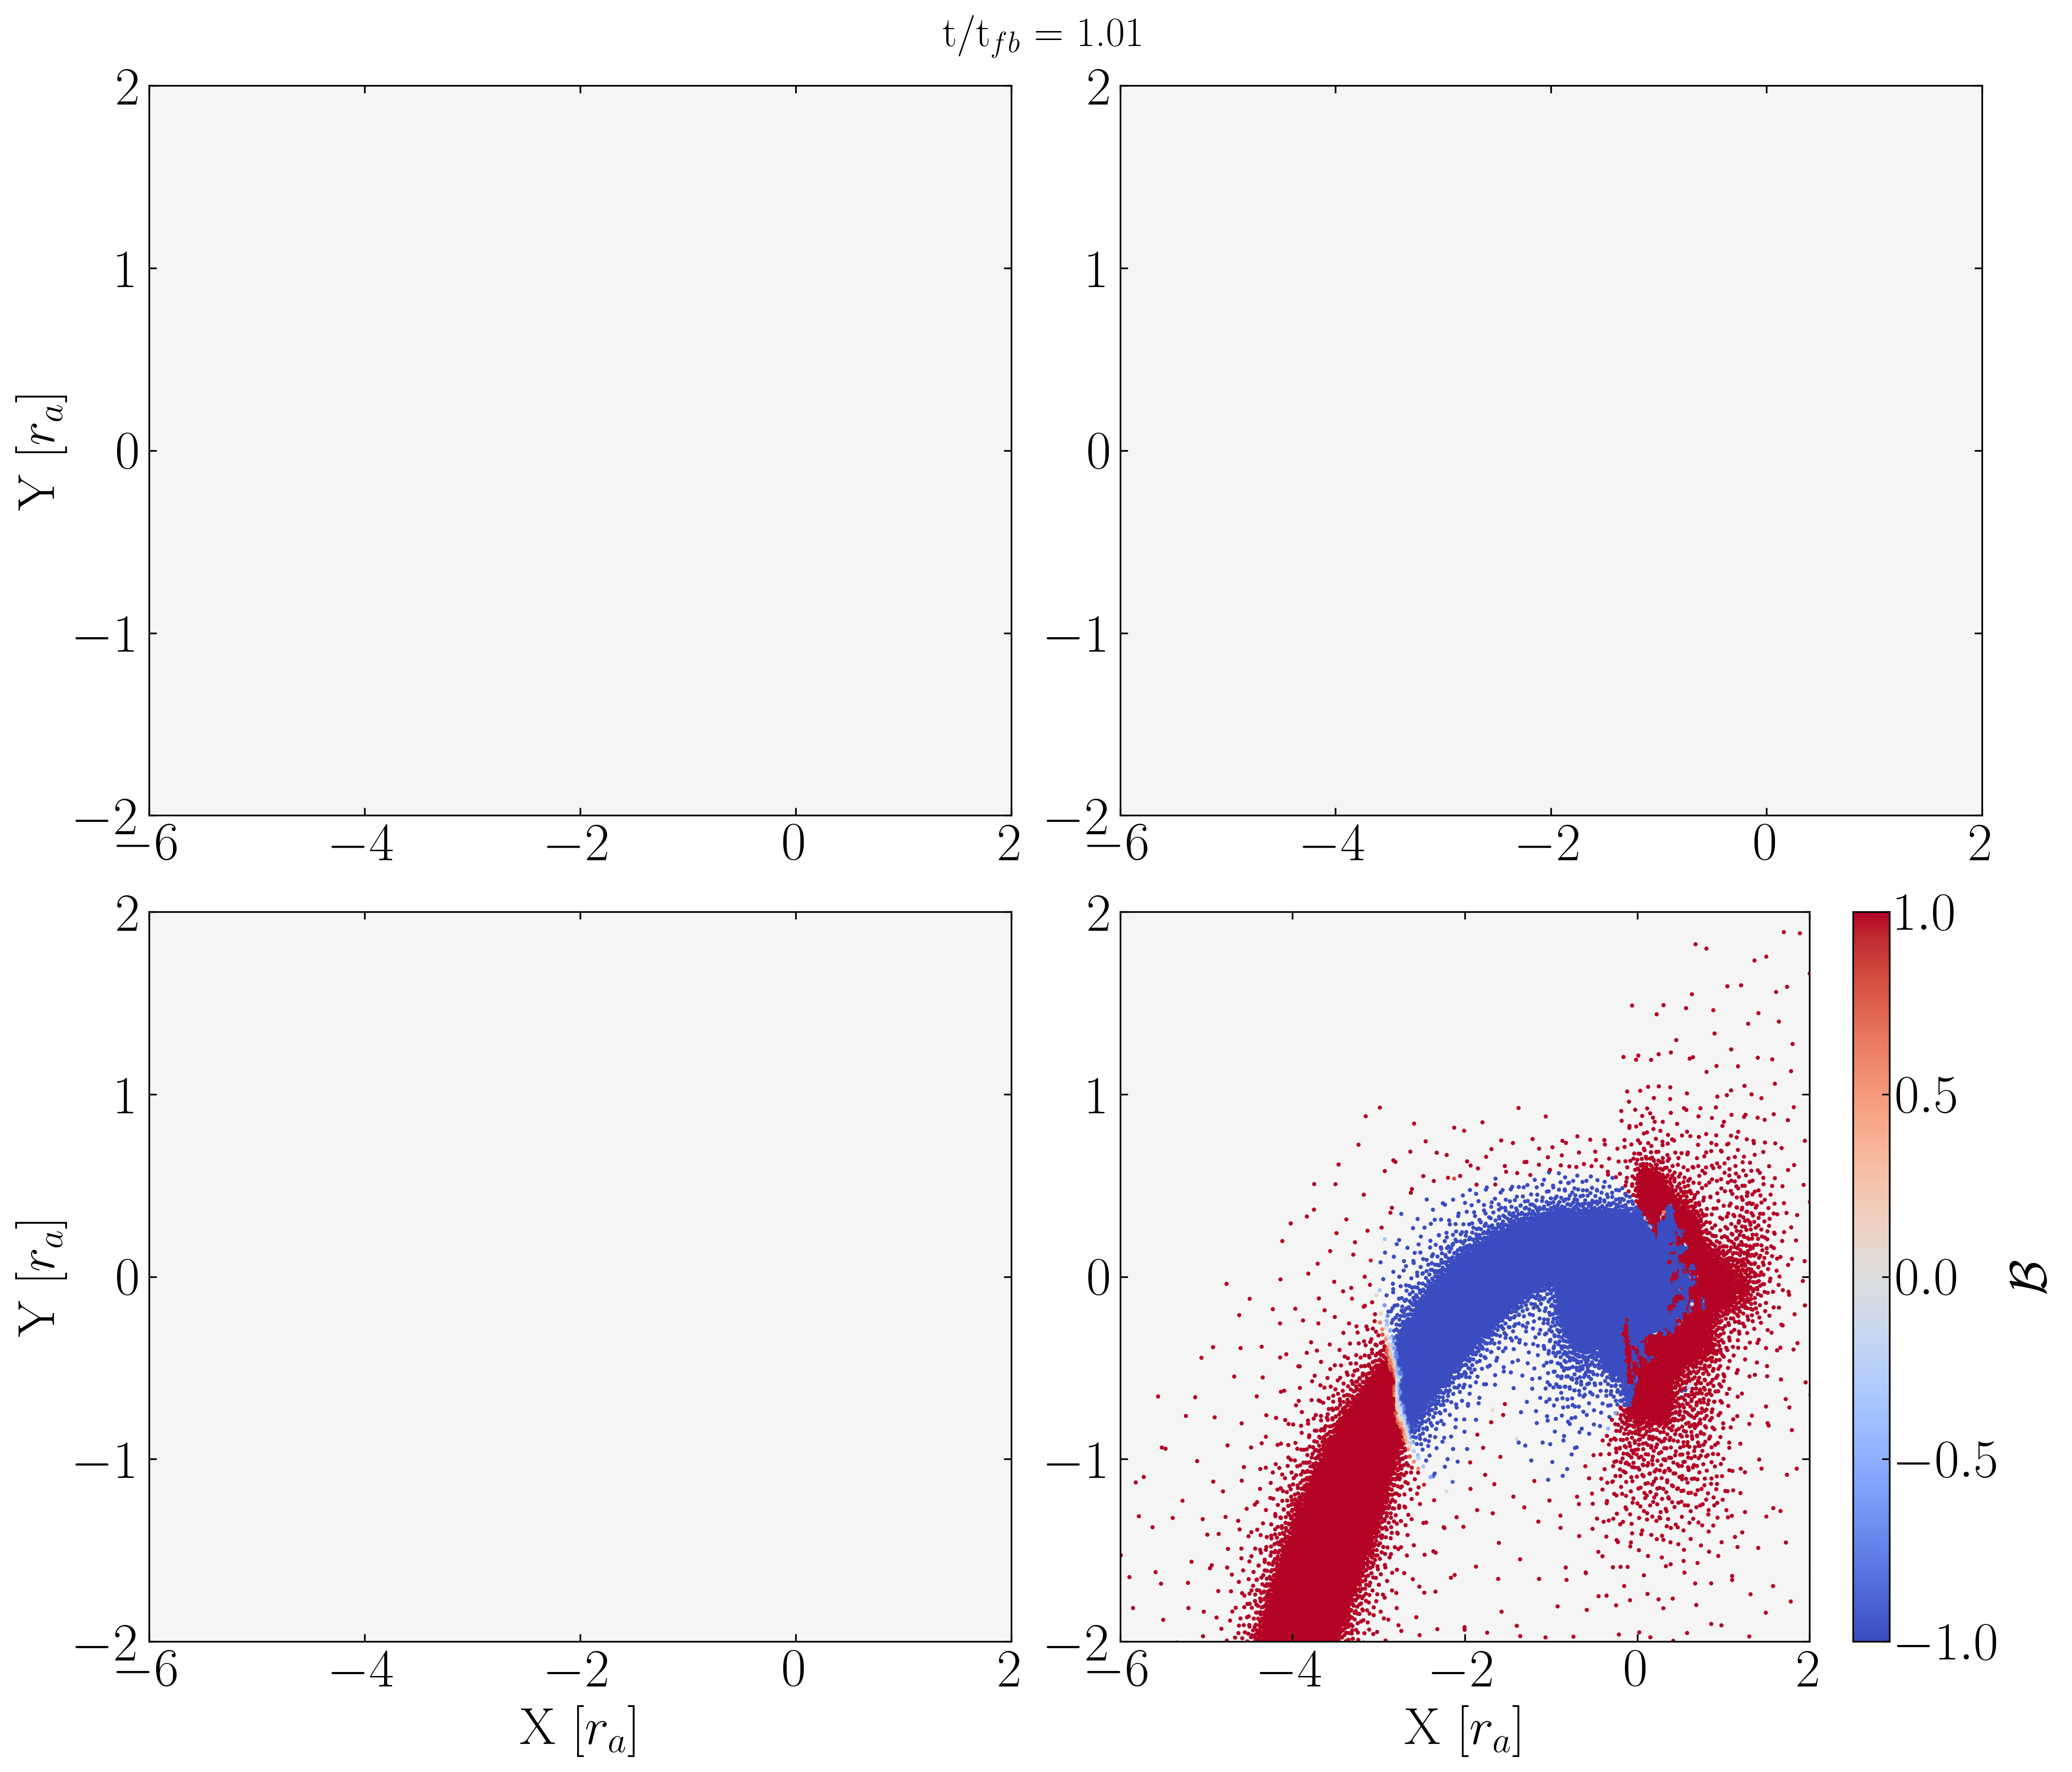

In [5]:
outflow_mid = np.logical_and(bern_mid>= 0, v_rad_mid>0)
fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2,2, figsize = (14,12))
# img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Temp_midplane*1e-4, s = 1, vmin = 1, vmax = 10, cmap = 'rainbow')
# plt.colorbar(img, label = r'T [$10^4 K]$')
# img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = Trad_midplane*1e-4, s = 1, vmin = 1, vmax = 10, cmap = 'rainbow')
# cbar = plt.colorbar(img, label = r'T$_{\rm rad} [10^4 K]$')
# cbar.ax.tick_params(axis = 'both', length = 9, width = 1.2)
# cbar.ax.tick_params(axis = 'both', which = 'minor', length = 7, width = .8)
# img = ax3.scatter(X_midplane/apo, Y_midplane/apo, c = Diss_midplane_cgs, s = 1, norm = colors.LogNorm(vmin = 1e39, vmax = 1e42), cmap = 'rainbow')
# cbar = plt.colorbar(img, label = r'Diss [erg/s]')
# cbar.ax.tick_params(axis = 'both', length = 9, width = 1.2)
# cbar.ax.tick_params(axis = 'both', which = 'minor', length = 7, width = .8)
img = ax4.scatter(X_midplane/apo, Y_midplane/apo, c = bern_mid, s = 1, vmin = -1, vmax = 1, cmap = 'coolwarm')
cbar = plt.colorbar(img, label = r'$\mathcal{B}$')
 
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(-6, 2) 
    ax.set_ylim(-2, 2)
    if ax in [ax1, ax2]:
        ax.set_ylabel(r'Y [$r_a$]')
    if ax in [ax2, ax4]:
        ax.set_xlabel(r'X [$r_a$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}' , fontsize = 20)
plt.tight_layout()
# plt.savefig(f'{abspath}/Figs/next_meeting/section{check}{snap}.png', bbox_inches = 'tight')

In [ ]:
PressTOT_mid = (Press_midplane + Rad_den_mid/3)/Den_midplane 
Diss_midplane_cgs = Diss_den_midplane * prel.en_converter/prel.tsol_cgs
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (21,7))
img = ax1.scatter(X_midplane[bern_mid>0]/apo, Y_midplane[bern_mid>0]/apo, c = orb_en_mid[bern_mid>0]*prel.en_converter, s = 10, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e39, vmax = 5e41))
cbar = plt.colorbar(img)
cbar.set_label(r' positive OE [erg]')

img = ax2.scatter(X_midplane[np.logical_and(bern_mid>0, Diss_den_midplane>0)]/apo, Y_midplane[np.logical_and(bern_mid>0, Diss_den_midplane>0)]/apo, c = Diss_midplane_cgs[np.logical_and(bern_mid>0, Diss_den_midplane>0)], s = 10, cmap = 'viridis', norm = colors.LogNorm(vmin = 1e22, vmax = 1e30))
cbar = plt.colorbar(img)
cbar.set_label(r'Diss [erg/s]')

for ax in [ax1, ax2]:
    ax.set_xlim(-7, 5)
    ax.set_ylim(-1, 7)
    # ax.axvline(Rt, c = 'k')
    # ax.axvline(-Rt, c = 'k')
    # ax.axhline(Rt, c = 'k')
    # ax.axhline(-Rt, c = 'k')
    ax.set_xlabel(r'X [$R_a$]')
ax1.set_ylabel(r'Y [$R_a$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}, unbound (B>0) material', fontsize = 20)
plt.tight_layout()
# plt.savefig(f'{abspath}/Figs/Test/Energy/posOE_{check}{snap}.png')

In [ ]:
# consider all the  elements in indices, but not in position all_stream
indices_nostream = indices[~np.isin(indices, all_stream)]
# check_stream = indices[~np.isin(indices, indices_nostream)]
X_nostream, Y_nostream, Z_nostream, mass_nostream, den_nostream, dim_nostream, Temp_nostream = \
    make_slices([X, Y, Z, mass, den, dim_cell, Temp], indices_nostream)
mid_nostream = np.abs(Z_nostream) < dim_nostream
X_no_mid, Y_no_mid, Z_no_mid, mass_no_mid, den_no_mid, dim_no_mid, Temp_no_mid = \
    make_slices([X_nostream, Y_nostream, Z_nostream, mass_nostream, den_nostream, dim_nostream, Temp_nostream], mid_nostream)

fig, ax1 = plt.subplots(1,1, figsize = (9,6))
img = ax1.scatter(X_no_mid/Rt, Y_no_mid/Rt, c = den_no_mid, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-10, vmax = 1e-4))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho [M_\odot/R_\odot^3]$')
ax1.set_ylabel(r'Y [$R_t$]')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_xlabel(r'X [$R_t$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}', fontsize = 20)
plt.tight_layout()

In [ ]:
atRt_nostream_mid = np.logical_and(np.abs(X_nostream-Rt) < dim_nostream, np.abs(Z_nostream) < dim_nostream)
X_rt_no_stream, Y_rt_no_stream, Z_rt_no_stream, den_rt_no_stream = \
    make_slices([X_nostream, Y_nostream, Z_nostream, den_nostream], atRt_nostream_mid)

fig, ax1 = plt.subplots(1,1, figsize = (9,5))
img = ax1.scatter(Y_rt_no_stream, Z_rt_no_stream, c = den_rt_no_stream, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-10, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho [M_\odot/R_\odot^3]$')
ax1.set_ylabel(r'Z [$R_\odot$]')
ax1.set_xlim(-Rt, Rt)
ax1.set_ylim(-2, 2)
ax1.set_xlabel(r'Y [$R_\odot$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}', fontsize = 20)
plt.tight_layout()

In [ ]:
# Radiation pressure dominated?
fig, ax1 = plt.subplots(1,1, figsize = (9,5))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = ratio_regime_mid, s = 2, cmap = 'rainbow', norm = colors.LogNorm(vmin = 0.1, vmax = 10))
cbar = plt.colorbar(img)
cbar.set_label(r'$P_{\rm rad} / P_{\rm gas}$')
ax1.set_xlim(-5, 5)
ax1.set_ylim(-4, 4)
ax1.set_xlabel(r'X [$R_a$]')
ax1.set_ylabel(r'Y [$R_a$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}', fontsize = 20)
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (21,7), width_ratios=[1.5, 1])
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, 
            c = bern_mid/E_mb, vmin = -6, vmax = 10,
            cmap = 'jet', s = 2, label = r'B$ < 0$')    
cbar = plt.colorbar(img, label = r'$|\mathcal{B}/\Delta\epsilon|$')
ax1.scatter(x_stream/apo, y_stream/apo, c = 'k', s = 2, label = r'stream')
ax1.set_xlim(-4, 2)
ax1.set_ylim(-2,2)
ax1.set_xlabel(r'X [$R_a$]')
ax1.set_ylabel(r'Y [$R_a$]')

img = ax2.scatter(X_midplane/Rt, Y_midplane/Rt, 
            c = bern_mid/E_mb, vmin = -6, vmax = 0,
            cmap = 'viridis', s = 2, label = r'B$ < 0$')
cbar = plt.colorbar(img, label = r'$|\mathcal{B}/\Delta\epsilon|$')
ax2.scatter(x_stream/Rt, y_stream/Rt, c = 'k', s = 2, label = r'stream')
ax2.set_xlim(-1, 1)
ax2.set_ylim(-1,1)
ax2.set_xlabel(r'X [$R_t$]')
ax2.set_ylabel(r'Y [$R_t$]')
plt.suptitle(r't/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}, ($\Delta\epsilon=${np.round(E_mb,2)})' , fontsize = 20)
plt.tight_layout()

In [ ]:
Diss_den_midplane_cgs = Diss_den_midplane * prel.en_den_converter/prel.tsol_cgs
Den_diss_peri_cgs = Den_diss_peri * prel.den_converter
print('Diss at pericenter: ', Den_diss_peri_cgs)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
img = ax1.scatter(X_midplane[Diss_den_midplane>0]/apo, Y_midplane[Diss_den_midplane>0]/apo, c = Diss_midplane_cgs[Diss_den_midplane>0], s = 1, cmap = 'viridis', norm = colors.LogNorm(vmin = 1e30, vmax = 1e38))
cbar = plt.colorbar(img)
cbar.set_label(r'$\dot{E}_{\rm diss}$ [erg/s]')
ax1.set_title('Positive diss')

# img = ax2.scatter(X_midplane[Diss_den_midplane<0]/apo, Y_midplane[Diss_den_midplane<0]/apo, c = np.abs(Diss_den_midplane_cgs[Diss_den_midplane<0]), s = 1, cmap = 'viridis', norm = colors.LogNorm(vmin = 1e-1, vmax = 1e6))
# cbar = plt.colorbar(img)
# cbar.set_label(r'$|\dot{E}_{\rm diss}|$ [erg/s/cm$^3$]')
# ax2.set_title('Negative diss')

# if Den_diss_peri_cgs> 0:
#     ax1.scatter(X_peri/apo, Y_peri/apo, c = Den_diss_peri_cgs, s = 10, edgecolors = 'r', facecolors = 'none', label = r'R$_p$')
# else: 
#     ax2.scatter(X_peri/apo, Y_peri/apo, c = np.abs(Den_diss_peri_cgs), s = 10, edgecolors = 'r', facecolors = 'none', label = r'R$_p$')

for ax in [ax1, ax2]:
    ax.set_xlim(-10, 5)
    ax.set_ylim(-2, 7)
    ax.set_xlabel(r'X [$R_a$]')
    ax.legend(fontsize=14)
plt.suptitle(r'Dissipation density rate at t/t$_{fb}$ = ' + f'{np.round(tfb,2)}, run: {check_name}', fontsize = 20)
plt.tight_layout()

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (15,5))
img = ax1.scatter(X_midplane[bern_mid>0]/apo, Y_midplane[bern_mid>0]/apo, c = Mass_midplane[bern_mid>0], s = 2, cmap = 'viridis', norm = colors.LogNorm(vmin = 1e-12, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'Mass [$M_\odot$]')
ax1.set_xlim(-5.5, 2)
ax1.set_ylim(-2, 2)
ax1.set_xlabel(r'X [$R_a$]')
ax1.set_ylabel(r'Y [$R_a$]')
plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,2)), fontsize = 20)
plt.tight_layout()

YZ slice


In [ ]:
xchosen = Rp
yz = np.abs(X-xchosen) < dim_cell
X_yz, Y_yz, Z_yz, dim_yz, Mass_yz, Den_yz, Press_yz, Temp_yz, Diss_den_yz, VX_yz, VY_yz, VZ_yz, orb_en_yz, v_rad_yz = \
    sec.make_slices([X, Y, Z, dim_cell, mass, den, Press, Temp, Diss_den, vx, vy, vz, orb_en, v_rad], yz)


In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (12, 8))
img = ax1.scatter(Y_yz/Rt, Z_yz/Rt, c = np.abs(VZ_yz)/v_esc, s = 1, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-1, vmax = 10))
cbar = plt.colorbar(img)
cbar.set_label(r'$V_Z [v_{\rm esc} (R_{\rm p})]$')
ax1.set_xlabel(r'Y [$R_{\rm t}$]')
ax1.set_ylabel(r'Z [$R_{\rm t}$]')
ax1.set_xlim(-9, 9)
ax1.set_ylim(-9, 9)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,8))
img = ax1.scatter(Y_yz, Z_yz, c = Den_yz*prel.den_converter, s = 10, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-10, vmax = 4e-6))
cbar = plt.colorbar(img)
cbar.set_label(r'Density [g/cm$^3$]')
ax1.set_ylabel(r'Z [$R_\odot$]')

# ax2.scatter(Y_yz[np.logical_and(orb_en_yz>0, v_rad_yz<0)]/amin, Z_yz[np.logical_and(orb_en_yz>0, v_rad_yz<0)]/amin, s = 10, c = 'orange', label = 'in unbound')
# ax2.scatter(Y_yz[np.logical_and(orb_en_yz<0, v_rad_yz<0)]/amin, Z_yz[np.logical_and(orb_en_yz<0, v_rad_yz<0)]/amin, s = 10, c = 'b', label = 'in bound')
# ax2.scatter(Y_yz[np.logical_and(orb_en_yz<0, v_rad_yz>0)]/amin, Z_yz[np.logical_and(orb_en_yz<0, v_rad_yz>0)]/amin, s = 10, c = 'dodgerblue', label = 'out bound')
# ax2.scatter(Y_yz[np.logical_and(orb_en_yz>=0, v_rad_yz>=0)]/amin, Z_yz[np.logical_and(orb_en_yz>=0, v_rad_yz>=0)]/amin, s = 10, c = 'r', label = 'out unbound')
# # ax2.quiver(Y_yz[::1000]/amin, Z_yz[::1000]/amin, VY_yz[::1000]/140, VZ_yz[::1000]/140, angles='xy', scale_units='xy', scale=0.5, color="k", width=0.003, headwidth = 6)
# img = ax3.scatter(Y_yz/amin, Z_yz/amin, c = np.abs(v_rad_yz), norm = colors.LogNorm(vmin = 1e-1, vmax = 4e1), s = 10, cmap = 'rainbow')
# cbar = plt.colorbar(img)
# cbar.set_label(r'$v_R$ [code units]')
for ax in [ax1, ax2, ax3]:
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-Rp/2, Rp/2)
    ax.set_ylim(-Rp/2, Rp/2)
    ax.set_xlabel(r'Y [$R_\odot$]')
    ax.contour(xcfr_grid[2], ycfr_grid[2], cfr_grid[2], levels=[0], colors='k')
    # ax.axvline(0.5, color = 'k', linestyle = 'dotted')
    # ax.axhline(0.5, color = 'k', linestyle = 'dotted')
    # ax.axvline(-0.5, color = 'k', linestyle = 'dotted')
    # ax.axhline(-0.5, color = 'k', linestyle = 'dotted')
ax2.legend(fontsize = 20)   
plt.suptitle(r'Cross section, X=0, t/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()
# plt.savefig(f'{saving_path}/slices/yz{threshx}_{snap}.png')

In [ ]:
v_rad_05amin = v_rad[np.abs(Rsph-0.5*amin)<dim_cell]
rhov_05amin = den[np.abs(Rsph-0.5*amin)<dim_cell] * v_rad_05amin
plt.plot(np.abs(rhov_05amin[v_rad_05amin<0]), label = 'in')
plt.plot(rhov_05amin[v_rad_05amin>=0], label = 'out')
plt.legend()
plt.yscale('log')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,5))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane, s = 2, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-11, vmax = 1e-6))
cbar = plt.colorbar(img)
cbar.set_label(r'Density $[M_\odot]$')
ax1.set_ylabel(r'Y [$R_a$]')

# img = ax2.scatter(X_midplane/amin, Y_midplane/amin, s = 2, c = Diss_den_midplane*prel.en_den_converter/prel.tsol_cgs, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e2, vmax = 1e8))
img = ax2.scatter(X_midplane/amin, Y_midplane/amin, s = 2, c = Temp_midplane, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e3, vmax = 1e6))
cbar = plt.colorbar(img)
cbar.set_label(r'T [K]')
# cbar.set_label(r'Diss density rate [erg/s/cm$^3$]')
# ax2.quiver(X_midplane[::1000]/amin, Y_midplane[::1000]/amin, VY_mid[::1000]/140, VZ_mid[::1000]/140, angles='xy', scale_units='xy', scale=0.5, color="k", width=0.003, headwidth = 6)
for ax in [ax1, ax2]:
    ax.set_xlim(-1.2, 1)
    ax.set_ylim(-.5, .5)
    ax.set_xlabel(r'X [$R_a$]')
    # ax.contour(xcfr_grid[2], ycfr_grid[2], cfr_grid[2], levels=[0], colors='k')
    # ax.axvline(0.5, color = 'k', linestyle = 'dotted')
    # ax.axhline(0.5, color = 'k', linestyle = 'dotted')
    # ax.axvline(-0.5, color = 'k', linestyle = 'dotted')
    # ax.axhline(-0.5, color = 'k', linestyle = 'dotted')
plt.suptitle(r'Cross section, Z=0, t/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()


In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25,8))
img = ax1.scatter(X_midplane/amin, Y_midplane/amin, c = Den_midplane, s = 10, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-11, vmax = 1e-6))
cbar = plt.colorbar(img)
cbar.set_label(r'Density $[M_\odot]$')
ax1.set_ylabel(r'Y [$a_{mb}$]')

ax2.scatter(X_midplane[np.logical_and(orb_en_mid>0, v_rad_mid<0)]/amin, Y_midplane[np.logical_and(orb_en_mid>0, v_rad_mid<0)]/amin, s = 10, c = 'orange', label = 'in unbound')
ax2.scatter(X_midplane[np.logical_and(orb_en_mid<0, v_rad_mid<0)]/amin, Y_midplane[np.logical_and(orb_en_mid<0, v_rad_mid<0)]/amin, s = 10, c = 'b', label = 'in bound')
ax2.scatter(X_midplane[np.logical_and(orb_en_mid<0, v_rad_mid>0)]/amin, Y_midplane[np.logical_and(orb_en_mid<0, v_rad_mid>0)]/amin, s = 10, c = 'dodgerblue', label = 'out bound')
ax2.scatter(X_midplane[np.logical_and(orb_en_mid>=0, v_rad_mid>=0)]/amin, Y_midplane[np.logical_and(orb_en_mid>=0, v_rad_mid>=0)]/amin, s = 10, c = 'r', label = 'out unbound')

img = ax3.scatter(X_midplane/amin, Y_midplane/amin, c = np.abs(v_rad_mid), norm = colors.LogNorm(vmin = 1e-1, vmax = 3e1), s = 10, cmap = 'rainbow')
cbar = plt.colorbar(img)
cbar.set_label(r'$v_R$ [code units]')
# ax2.quiver(X_midplane[::1000]/amin, Y_midplane[::1000]/amin, VY_mid[::1000]/140, VZ_mid[::1000]/140, angles='xy', scale_units='xy', scale=0.5, color="k", width=0.003, headwidth = 6)
for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-10, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r'X [$a_{mb}$]')
    ax.contour(xcfr_grid[2], ycfr_grid[2], cfr_grid[2], levels=[0], colors='k')
    ax.axvline(0.5, color = 'k', linestyle = 'dotted')
    ax.axhline(0.5, color = 'k', linestyle = 'dotted')
    ax.axvline(-0.5, color = 'k', linestyle = 'dotted')
    ax.axhline(-0.5, color = 'k', linestyle = 'dotted')
ax2.legend(fontsize = 20)   
plt.suptitle(r'Cross section, Z=0, t/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()


In [ ]:
# are we pressure dominated?
RadP_P = np.abs(prel.alpha_cgs/(3*prel.en_den_converter) * Temp**4 / Press)
RadP_P = np.abs(prel.alpha_cgs/(3*prel.en_den_converter) * Temp**4 / Press)
RadP_Pmid = np.abs(prel.alpha_cgs/(3*prel.en_den_converter) * Temp_midplane**4 / Press_midplane)
plt.scatter(X_midplane/apo, Y_midplane/apo, c = RadP_Pmid, s = 5, cmap = 'rainbow', norm = colors.LogNorm(vmin = 1e-2, vmax = 1e2))
plt.colorbar(label = r'$\frac{P_{\rm rad}}{P_{\rm gas}}$')
plt.xlabel(r'X [$R_{a}$]')
plt.ylabel(r'Y [$R_{a}$]')
plt.xlim(-7,3)
plt.ylim(-4,4)
plt.title(f'Total radiation dominated cells: {int(len(RadP_P[RadP_P>=1])/len(RadP_P)*100)}\% ' + r'at t/t$_{\rm fb}$ = ' + str(np.round(tfb,2)), fontsize = 18)
plt.savefig(f'{saving_path}pressure_dom{snap}.png')


In [ ]:
theta_prec = orb.precession_angle(Rstar, mstar, Mbh, beta, prel.csol_cgs, prel.G)
R_si = orb.R_selfinter(Rstar, mstar, Mbh, beta, prel.csol_cgs, prel.G)
print(f'Precession angle: {theta_prec} rad, {theta_prec*180/np.pi} degrees')
print(f'Self-intersection radius: {R_si} Rsol')


In [ ]:
import matlab.engine
from src.Opacity.linextrapolator import nouveau_rich
eng = matlab.engine.start_matlab()
opac_path = f'{abspath}/src/Opacity'
T_cool = np.loadtxt(f'{opac_path}/T.txt')
Rho_cool = np.loadtxt(f'{opac_path}/rho.txt')
rossland = np.loadtxt(f'{opac_path}/ross.txt')
T_cool2, Rho_cool2, rossland2 = nouveau_rich(T_cool, Rho_cool, rossland, what = 'scattering', slope_length = 5)
sigma_rossland = eng.interp2(T_cool2, Rho_cool2, rossland2.T, np.log(Temp_midplane), np.log(Den_midplane_cgs), 'linear', 0)
sigma_rossland = np.array(sigma_rossland)[0]
sigma_rossland_eval = np.exp(sigma_rossland) # [1/cm]
sigma_rossland_eval[sigma_rossland == 0.0] = 1e-20
tau_mid = sigma_rossland_eval * dim_midplane * prel.Rsol_cgs 
scatt_mid = 0.34*Den_midplane*prel.den_converter * dim_midplane * prel.Rsol_cgs

fig, ax1 = plt.subplots(1,1, figsize = (8,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Mass_midplane, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 1e-12, vmax = 1e-9))
cbar = plt.colorbar(img)
cbar.set_label(r'Mass', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)
ax1.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.title(f'{folder} ' + r't/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()

fig, ax2 = plt.subplots(1,1, figsize = (8,6))
img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = tau_mid, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 9e-1, vmax = 1e4))
cbar = plt.colorbar(img)
cbar.set_label(r'$\tau$', fontsize = 16)
for ax in [ax1, ax2]:
    ax.axhline(2*Rt/apo, c = 'k')
    ax.axhline(-2*Rt/apo, c = 'k')
    ax.axvline(2*Rt/apo, c = 'k')
    ax.axvline(-2*Rt/apo, c = 'k')
    ax.set_xlim(-.2,.2)
    ax.set_ylim(-.2, .2)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.title(f'{folder} ' + r't/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()
    

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (8,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Diss_den_midplane, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 5e-10, vmax = 1e-7))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)
ax1.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.title(f'{folder} ' + r't/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (25,12))
img = ax1.scatter(X_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, Y_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, c = Den_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]*prel.den_converter, s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin =1e-8, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, Y_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, c = Mass_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)], s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin = 2e-6, vmax = 5e-4))
cbar = plt.colorbar(img)
cbar.set_label(r'mass [M$_\odot$]', fontsize = 16)

img = ax3.scatter(X_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, Y_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)]/apo, c = dim_midplane[np.logical_and(orb_en_spec_mid>0.5*delta_E, orb_en_spec_mid<0.6*delta_E)], s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin = 1, vmax = 20))
cbar = plt.colorbar(img)
cbar.set_label(r'R [R$_\odot$]', fontsize = 16)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(-6, -2)
    ax.set_ylim(-3, 0)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)

img = ax4.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane*prel.den_converter, s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin =1e-8, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax5.scatter(X_midplane/apo, Y_midplane/apo, c = Mass_midplane, s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin=2e-10, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'mass [M$_\odot$]', fontsize = 16)

img = ax6.scatter(X_midplane/apo, Y_midplane/apo, c = dim_midplane, s = 2, cmap = 'turbo', norm = colors.LogNorm(vmin = 4e-2, vmax = 2))
cbar = plt.colorbar(img)
cbar.set_label(r'R [R$_\odot$]', fontsize = 16)

for ax in [ax4, ax5, ax6]:
    ax.set_xlim(-.2, .2)
    ax.set_ylim(-.2, .2)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)

plt.suptitle(f'tot cells in the box {int(len(data.X)*1e-6)}' + r'$\cdot10^6$' + f', {check}', fontsize = 20)
plt.tight_layout()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane*prel.den_converter, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin =1e-8, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = kappa_mid, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 1e-2, vmax=1e5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\kappa$', fontsize = 16)
# img = ax2.scatter(X_midplane[kappa_mid<20]/apo, Y_midplane[kappa_mid<20]/apo, c = 'b', s = 1)

for ax in [ax1, ax2]:
    # ax.scatter(observers_xyz[90:94,0], observers_xyz[90:94,1], c = 'k', s=20, label = 'observers')
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.suptitle(r'Orbital plane, t/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)
plt.tight_layout()
plt.savefig(f'{saving_path}kappa_{snap}.png')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane*prel.den_converter, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin =1e-8, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\rho$ [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = kappa_mid, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 1e-2, vmax=1e5))
cbar = plt.colorbar(img)
cbar.set_label(r'$\kappa$', fontsize = 16)
img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = Temp_midplane, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin = 1e3, vmax=1e6))
cbar = plt.colorbar(img)

for ax in [ax1, ax2]:
    ax.scatter(observers_xyz[90:94,0], observers_xyz[90:94,1], c = 'k', s=20, label = 'observers')
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
ax2.legend()
plt.suptitle(r'Orbital plane, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
# plt.savefig(f'{saving_path}kappa_{snap}.png')

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (14,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Den_midplane*prel.den_converter, s = 1, cmap = 'turbo', norm = colors.LogNorm(vmin =1e-12, vmax = 1e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'Density [g/cm$^3$]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)
ax1.set_xlim(-4,.5)
ax1.set_ylim(-.5, .5)
ax1.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.title(f'{folder} ' + r't/t$_{fb}$ = ' + str(np.round(tfb,3)), fontsize = 20)

In [ ]:
idxRp_lines_mid = np.concatenate(np.where(np.logical_and(np.abs(Y_midplane)<dim_midplane, np.abs(X_midplane-Rp)<dim_midplane))) #X=Rp, Y=0
PressRp_mid, DenRp_mid, XRp_mid, YRp_mid, dimRp_mid, TRp_mid = Press_midplane[idxRp_lines_mid], Den_midplane[idxRp_lines_mid], X_midplane[idxRp_lines_mid], Y_midplane[idxRp_lines_mid], dim_midplane[idxRp_lines_mid], Temp_midplane[idxRp_lines_mid]
idxRp_mid = np.argmin(np.abs(XRp_mid-Rp)) #Z=0, Y=0, X=Rp
print('Rp coordinates X, Y: ', XRp_mid[idxRp_mid], YRp_mid[idxRp_mid])
csRp_mid = np.sqrt(PressRp_mid[idxRp_mid]/DenRp_mid[idxRp_mid])
Hrp_mid = csRp_mid/omegaRp
print(f'Minimum R cell size: {np.min(dim_midplane)}')
print(f'T = {TRp_mid[idxRp_mid]/1e6} 1e6 K')
print(f'Cs at Rp: {csRp_mid*prel.Rsol_cgs*1e-7/prel.tsol_cgs} 1e-7 cm/s \nH at Rp: {Hrp_mid} Rsol')
print(f'max numbers of cell in H: {Hrp_mid/np.min(dim_midplane)}')

In [ ]:
absvel = True
fig, ax = plt.subplots(1,1, figsize = (12,6))
if absvel:
    img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = np.abs(v_rad_mid_kms), s = 4, cmap = 'jet', norm = colors.LogNorm(vmin = 5e2, vmax = 2e4))
else:
    img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = v_rad_mid_kms*1e-4, s = 4, cmap = 'jet', vmin = -1, vmax = 1)#, vmin = 5e2, vmax = 2e4)
cbar = plt.colorbar(img)
ax.scatter(xph[indecesorbital]/apo, yph[indecesorbital]/apo, facecolor = 'none', edgecolors = 'k')
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-6, 2.5)
ax.set_ylim(-3, 2)
ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_a$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
if absvel:
    cbar.set_label(r'$|$Radial velocity$|$ [km/s]', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'{saving_path}/slices/absvel{snap}.png')
else:
    cbar.set_label(r'Radial velocity [10$^4$ km/s]', fontsize = 16)
    plt.tight_layout()
    plt.savefig(f'{saving_path}/slices/vel{snap}.png')


In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
img = ax1.scatter(X_midplane/apo, Y_midplane/apo, c = Diss_midplane, s = 1, cmap = 'inferno', vmin = -1e-15, vmax = 1e-15)
cbar = plt.colorbar(img)
cbar.set_label(r'Dissipation rate [energy/time]', fontsize = 16)
ax1.set_ylabel(r'Y [$R_a$]', fontsize = 18)

img = ax2.scatter(X_midplane/apo, Y_midplane/apo, c = divV_mid, s = 1, cmap = 'inferno', vmin = -1, vmax=1)#1e2, vmax = 1e9)
cbar = plt.colorbar(img)
cbar.set_label(r'$\nabla v$ [1/time]', fontsize = 16)
for ax in [ax1, ax2]:
    ax.scatter(0,0,c= 'k', marker = 'x', s=80)
    ax.set_xlim(-1.2, 0.3)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'X [$R_a$]', fontsize = 18)
plt.suptitle(r'Orbital plane, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
plt.savefig(f'{saving_path}midplaneDiss_{snap}.png')

In [ ]:
# fig, ax = plt.subplots(1,1, figsize = (12,4))
# img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = EdotDiss_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin = 1e-15, vmax = 1e-6))
# cbar = plt.colorbar(img)
# cbar.set_label(r'$\dot{E}_{diss}$ ', fontsize = 16)
# ax.scatter(0,0,c= 'k', marker = 'x', s=80)
# ax.text(-3.5,1.5, r'E diss tot =' + str(np.round(np.sum(Edot_diss)*1e5,2)) + r'$x$1e-5', fontsize = 16)
# ax.text(-3.5,1, r'E diss mid =' + str(np.round(np.sum(EdotDiss_midplane)*1e5,2)) + r'$x$1e-5', fontsize = 16)
# ax.set_xlim(-4,0.5)
# ax.set_ylim(-2,2)
# ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
# ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
# plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)) + f', check = {check}', fontsize = 18)

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = Rad_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin= 1e-8, vmax = 5e-5))
cbar = plt.colorbar(img)
cbar.set_label(r'Energy density [erg/cm$^3$]', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-1,0.1)
ax.set_ylim(-0.5,0.5)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (12,4))
img = ax.scatter(X_midplane/apo, Y_midplane/apo, c = L_midplane, s = 1, cmap = 'jet', norm = colors.LogNorm(vmin= 1e40, vmax = 1e46))
cbar = plt.colorbar(img)
cbar.set_label(r'Luminosity [erg/s]', fontsize = 16)
ax.scatter(0,0,c= 'k', marker = 'x', s=80)
ax.set_xlim(-8,0.1)
ax.set_ylim(-2,2)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

In [ ]:
# search for indeces to explore
theta_arr, x_stream, y_stream, z_stream, thresh_cm = np.load(f'/Users/paolamartire/shocks/data/{folder}/stream_{check}{snap}.npy')
selected_indeces = np.arange(30,230,20)
plt.plot(x_stream, y_stream, c = 'k')
plt.scatter(x_stream[80], y_stream[80], c = 'k')
plt.xlim(-apo,100)
plt.ylim(-100,100)

Tangent and transverse plane

In [ ]:
idx = 80
condition_tra, x_onplane, x0 = sec.transverse_plane(X, Y, Z, dim_cell, x_stream, y_stream, z_stream, idx, coord= True)
X_tra, Y_tra, Z_tra, Vz_tra, Den_tra, Mass_tra, dim_tra = \
    sec.make_slices([X, Y, Z, vz, den, mass, dim_cell], condition_tra)
X_tra_midplane = X_tra[np.abs(Z_tra) < dim_tra]
Y_tra_midplane = Y_tra[np.abs(Z_tra) < dim_tra]

Plot as BonnerotLu22

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4))
ax1.scatter(x_onplane/Rstar, Den_tra, s=.1, c='k')
ax1.set_xlabel(r'T/R$_\star$')
ax1.set_ylabel(r'Density [M$_\odot$/R$_\odot^3$]')
ax1.set_xlim(-15,15)
ax1.grid()

ax2.scatter(Z_tra/Rstar, Vz_tra, s=.1, c='k')
ax2.set_xlabel(r'Z/R$_\star$')
ax2.set_ylabel(r'V$_z [R_\odot/\tilde{t}$]')
ax2.set_xlim(-6.5,6.5)
ax2.set_ylim(-0.5, 0.5)
ax2.grid()

plt.tight_layout()
plt.suptitle('Reproducing Fig.3 from BonnerotLu22')

In [ ]:
indeces_boundary, x_T_width, w_params, h_params, thresh = orb.find_single_boundaries(data.X, data.Y, data.Z, dim_cell, data.Mass, stream , idx, params)

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (14,4), gridspec_kw = {'width_ratios': [2, 1]})
# img = ax[0].scatter(X_midplane, Y_midplane, c = Den_midplane, s = .1, cmap = 'viridis', vmin = 0.1*np.max(Den_tra), vmax = np.max(Den_tra))
# cbar = plt.colorbar(img)
# cbar.set_label(r' Density', fontsize = 16)
# ax[0].scatter(X_tra_midplane, Y_tra_midplane, s = 1, c = 'k')
# ax[0].set_xlim(-300,20)
# ax[0].set_ylim(-60,60)

img1 = ax[1].scatter(x_onplane, Z_tra, c = Den_tra,  cmap = 'viridis', s = 2, vmin = 0.1*np.max(Den_tra), vmax = np.max(Den_tra))
cbar1 = plt.colorbar(img1)
cbar1.set_label(r'Density', fontsize = 16)
ax[1].scatter(0, z_stream[idx], marker = 'x', s = 10, c = 'k', alpha = 1)
# ax[1].axvline(x_T_width[0], c = 'r')
# ax[1].axvline(x_T_width[1], c = 'r') # T coordinates for width
# ax[1].axvline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
# ax[1].axvline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
# ax[1].text(0.9*thresh, -1.8*thresh, 'cutoff',fontsize = 11, rotation = 90,  bbox=dict(facecolor='white', alpha=0.8))
ax[1].set_xlim(-15,15)#2*thresh, 2*thresh)
ax[1].set_ylim(-15,15)#2*thresh, 2*thresh)

# ax[1].axhline(data.Z[indeces_boundary[2]], c = 'r')
# ax[1].axhline(data.Z[indeces_boundary[3]], c = 'r')
# ax[1].axhline(-thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
# ax[1].axhline(thresh, linestyle = 'dashed', c = 'k', alpha = 0.8)
# ax[1].set_ylim(-2*thresh, 2*thresh)

ax[1].set_ylabel(r'Z [$R_\odot$]', fontsize = 18) 
# plt.suptitle(f'{check}, cells W: {int(w_params[1])}, cells H: {int(h_params[1])}, theta: {np.round(theta_arr[idx], 2)}', fontsize = 16)
plt.tight_layout()


In [ ]:
len(x_onplane)